In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
GROQ_API_KEY = os.getenv("GROQ_API_KEY")
LANGSMITH_API_KEY = os.getenv("LANGSMITH_API_KEY")
LANGSMITH_PROJECT = os.getenv("LANGSMITH_PROJECT")
LANGSMITH_ENDPOINT = os.getenv("LANGSMITH_ENDPOINT")
LANGSMITH_TRACING = os.getenv("LANGSMITH_TRACING")
CDP_API_KEY_NAME = os.getenv("CDP_API_KEY_NAME")
CDP_API_KEY_PRIVATE_KEY = os.getenv("CDP_API_KEY_PRIVATE_KEY")
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
ARCADE_API_KEY = os.getenv("ARCADE_API_KEY")

In [4]:
os.environ["GROQ_API_KEY"] = GROQ_API_KEY
os.environ["LANGSMITH_API_KEY"] = LANGSMITH_API_KEY
os.environ["LANGSMITH_PROJECT"] = LANGSMITH_PROJECT
os.environ["LANGSMITH_ENDPOINT"] = LANGSMITH_ENDPOINT
os.environ["LANGSMITH_TRACING"] = LANGSMITH_TRACING
os.environ["CDP_API_KEY_PRIVATE_KEY"] = CDP_API_KEY_PRIVATE_KEY
os.environ["CDP_API_KEY_NAME"] = CDP_API_KEY_NAME
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
os.environ["ARCADE_API_KEY"] = ARCADE_API_KEY

In [5]:
from langchain_arcade import ArcadeToolManager
tool_manager = ArcadeToolManager(api_key=ARCADE_API_KEY)
tools = tool_manager.get_tools(toolkits=["X"])
print(tools)

[StructuredTool(name='X_DeleteTweetById', description='Delete a tweet on X (Twitter).', args_schema=<class 'langchain_arcade._utilities.DeleteTweetByIdArgs'>, func=<function create_tool_function.<locals>.tool_function at 0x000001D6E44B28E0>), StructuredTool(name='X_LookupSingleUserByUsername', description='Look up a user on X (Twitter) by their username.', args_schema=<class 'langchain_arcade._utilities.LookupSingleUserByUsernameArgs'>, func=<function create_tool_function.<locals>.tool_function at 0x000001D6E338FEC0>), StructuredTool(name='X_LookupTweetById', description='Look up a tweet on X (Twitter) by tweet ID.', args_schema=<class 'langchain_arcade._utilities.LookupTweetByIdArgs'>, func=<function create_tool_function.<locals>.tool_function at 0x000001D6E44E0220>), StructuredTool(name='X_PostTweet', description='Post a tweet to X (Twitter).', args_schema=<class 'langchain_arcade._utilities.PostTweetArgs'>, func=<function create_tool_function.<locals>.tool_function at 0x000001D6E44E

In [6]:
from langchain_google_genai import ChatGoogleGenerativeAI
model = ChatGoogleGenerativeAI(model="gemini-1.5-pro")
model_with_tools = model.bind_tools(tools)

C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
from langgraph.graph import MessagesState,START,END,StateGraph
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver
def call_agent(state: MessagesState):
    messages = state["messages"]
    response = model_with_tools.invoke(messages)
    # Return the updated message history
    return {"messages": [response]}
 
 
# Function to determine the next step in the workflow based on the last message
def should_continue(state: MessagesState):
    if state["messages"][-1].tool_calls:
        for tool_call in state["messages"][-1].tool_calls:
            if tool_manager.requires_auth(tool_call["name"]):
                return "authorization"
        return "tools"  # Proceed to tool execution if no authorization is needed
    return END  # End the workflow if no tool calls are present
 
 
# Function to handle authorization for tools that require it
def authorize(state: MessagesState, config: dict):
    user_id = config["configurable"].get("user_id")
    for tool_call in state["messages"][-1].tool_calls:
        tool_name = tool_call["name"]
        if not tool_manager.requires_auth(tool_name):
            continue
        auth_response = tool_manager.authorize(tool_name, user_id)
        if auth_response.status != "completed":
            # Prompt the user to visit the authorization URL
            print(f"Visit the following URL to authorize: {auth_response.url}")
 
            # Wait for the user to complete the authorization
            # and then check the authorization status again
            tool_manager.wait_for_auth(auth_response.id)
            if not tool_manager.is_authorized(auth_response.id):
                # This stops execution if authorization fails
                raise ValueError("Authorization failed")
 
    return {"messages": []}

In [8]:
workflow = StateGraph(MessagesState)
 
# Add nodes (steps) to the graph
workflow.add_node("agent", call_agent)
workflow.add_node("tools", ToolNode(tools=tools))
workflow.add_node("authorization", authorize)

# Define the edges and control flow between nodes
workflow.add_edge(START, "agent")
workflow.add_conditional_edges("agent", should_continue, ["authorization", "tools", END])
workflow.add_edge("authorization", "tools")
workflow.add_edge("tools", "agent")

# Set up memory for checkpointing the state
memory = MemorySaver()

# Compile the graph with the checkpointer
arcadeai_agent = workflow.compile(checkpointer=memory)

# Configuration with thread and user IDs for authorization purposes
config = {"configurable": {"thread_id": "1", "user_id": "user@example.com"}}

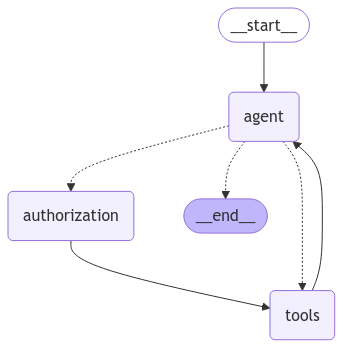

In [9]:
from IPython.display import Image, display
display(Image(arcadeai_agent.get_graph(xray=True).draw_mermaid_png()))
config = {"configurable": {"thread_id": "1", "user_id": "user@example.com"}}

In [13]:
# from langchain_core.messages import HumanMessage, SystemMessage


# messages = [HumanMessage(content="")]
# messages = arcadeai_agent.invoke({"messages": messages},config,stream_mode="values")

# # messages["messages"][-2:]

# for m in messages["messages"][-2:]:
#     m.pretty_print()

================================ Human Message =================================

What was my previous question
================================== Ai Message ==================================

Your previous question was: "Tweet a short story from my account and provide link of this tweet"
